Best Epoch for ShallowPrivateSpatialDictNetSlow: 1661.0
Validation Loss at Best Epoch: 1.5602
Validation Accuracy at Best Epoch: 0.4758
Training Accuracy at Best Epoch: 0.7762


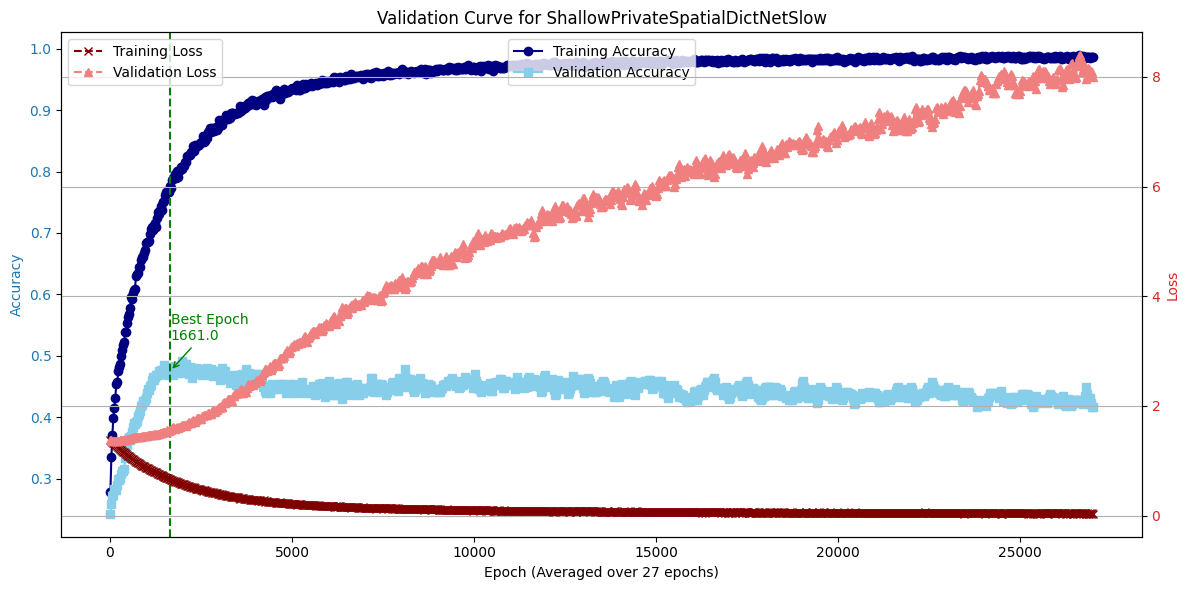

Best Epoch for SubjectDicionaryFCNet: 1661.0
Validation Loss at Best Epoch: 1.3267
Validation Accuracy at Best Epoch: 0.4066
Training Accuracy at Best Epoch: 0.6156


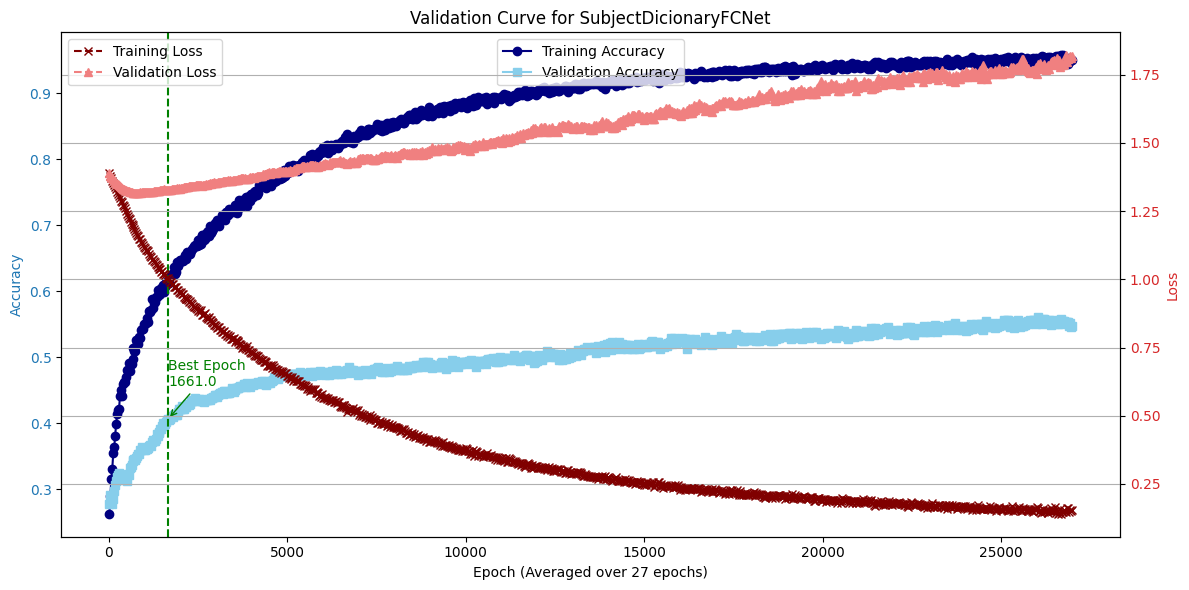

Best Epoch for ShallowPrivateTemporalDictNetSlow: 1661.0
Validation Loss at Best Epoch: 1.5716
Validation Accuracy at Best Epoch: 0.4320
Training Accuracy at Best Epoch: 0.7464


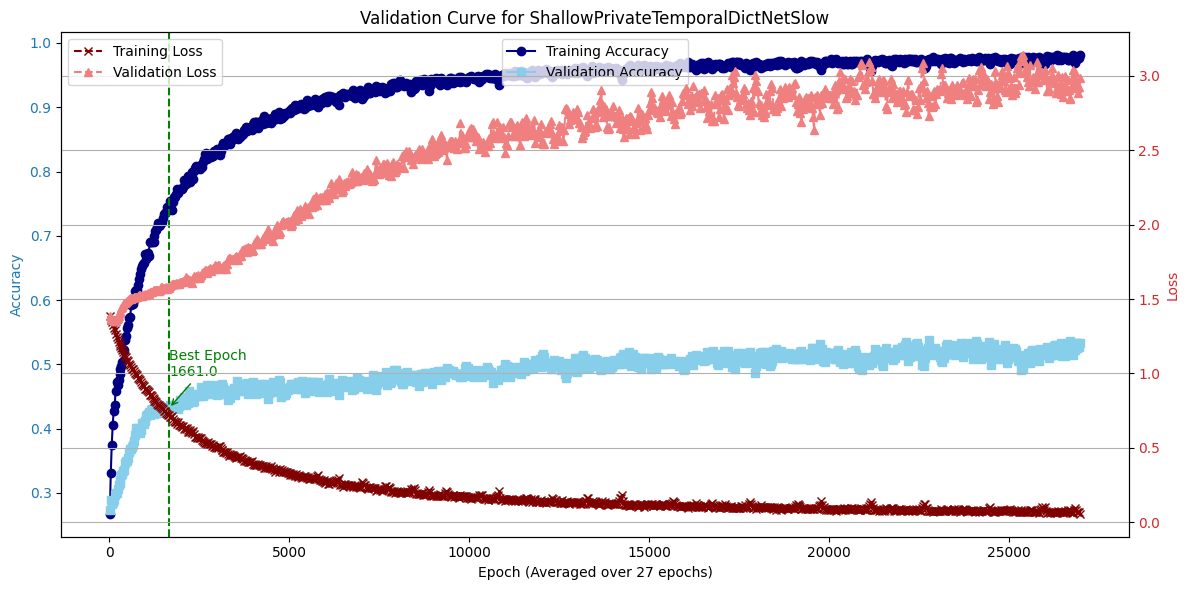

Best Epoch for ShallowPrivateCollapsedDictNetSlow: 7952.0
Validation Loss at Best Epoch: 1.1001
Validation Accuracy at Best Epoch: 0.5395
Training Accuracy at Best Epoch: 0.9303


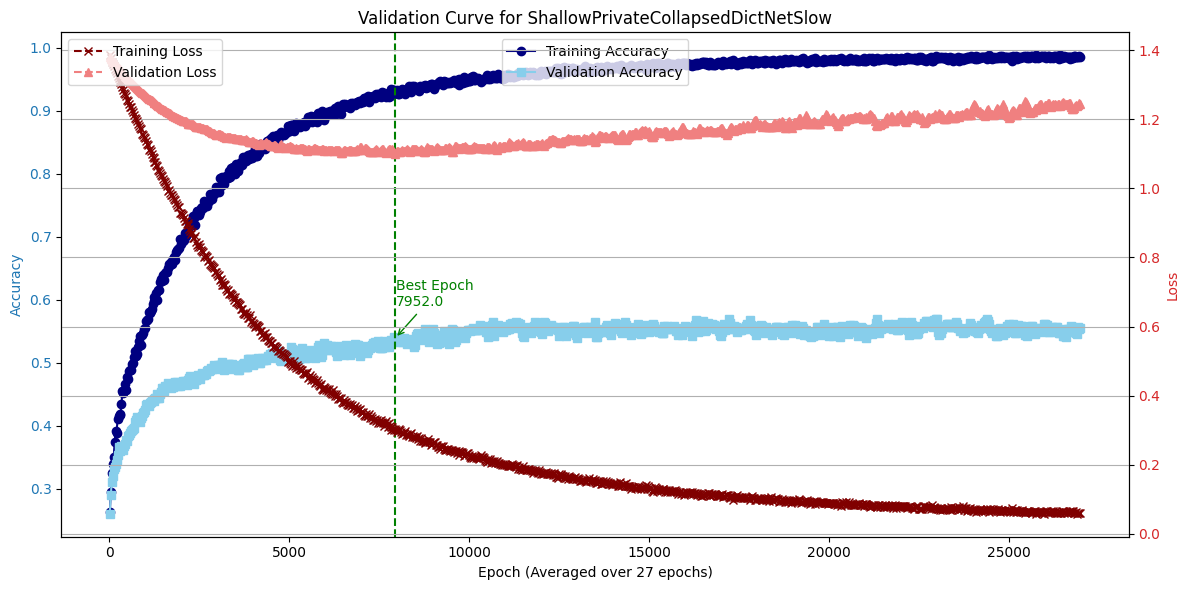

Best Epoch for ShallowFBCSPNet: 6062.0
Validation Loss at Best Epoch: 1.2926
Validation Accuracy at Best Epoch: 0.5487
Training Accuracy at Best Epoch: 0.7812


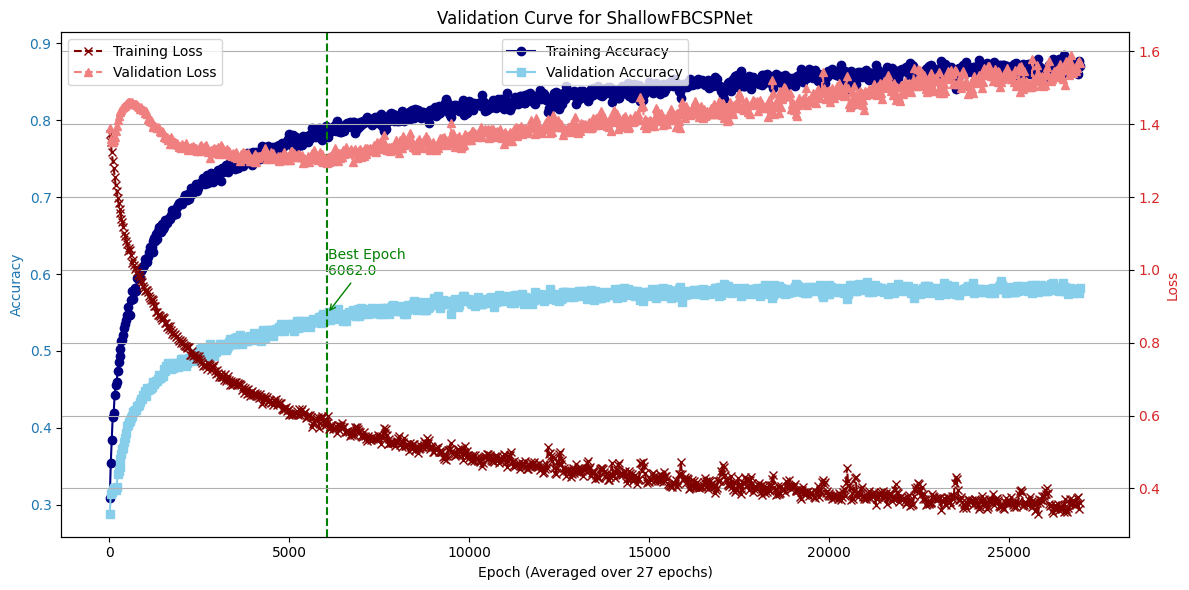

Best Epoch for CollapsedShallowNet: 7304.0
Validation Loss at Best Epoch: 1.3342
Validation Accuracy at Best Epoch: 0.5568
Training Accuracy at Best Epoch: 0.7727


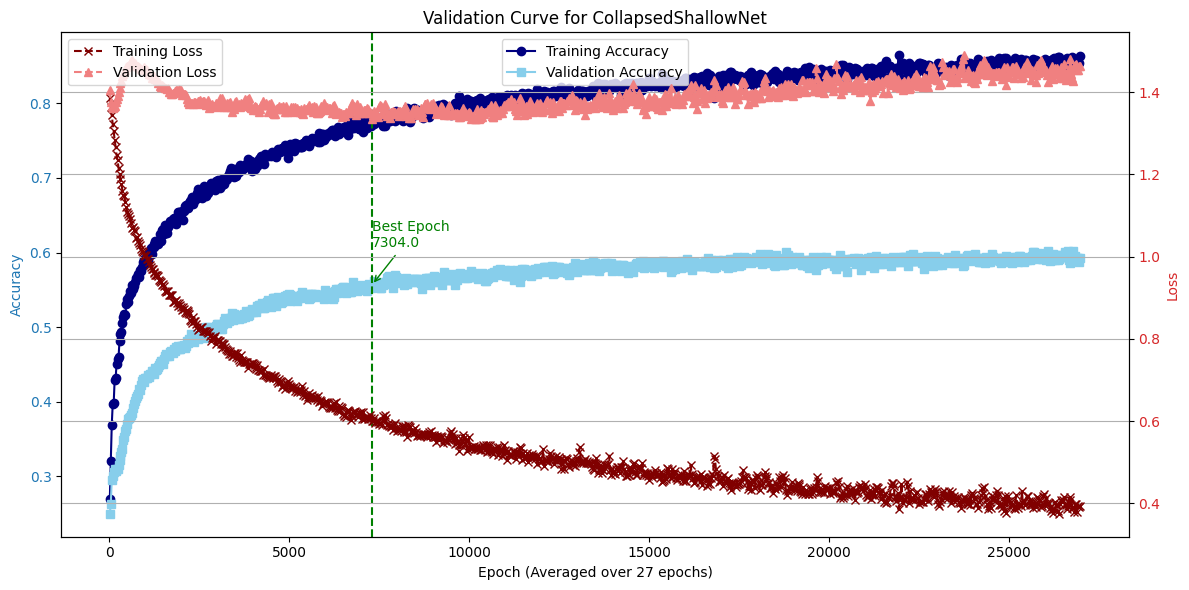

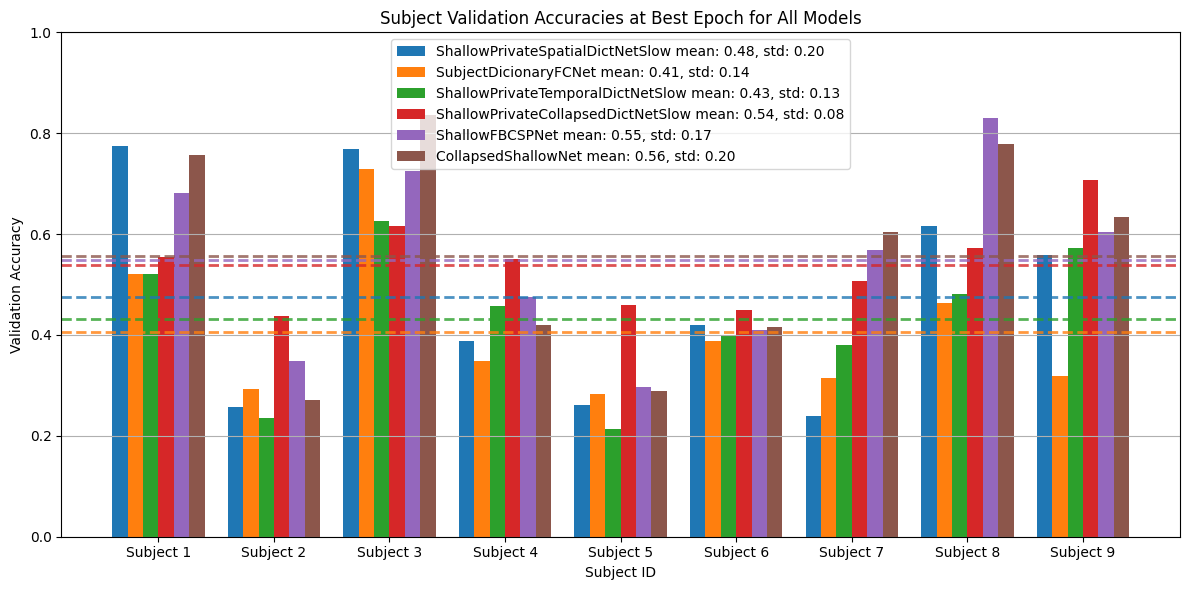

In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np

model_data = []
current_model = None
epoch_data = []

# Regex patterns
epoch_pattern = re.compile(
    r'^\s*(\d+)\s+([\d\.\x1b\[\]m]+)\s+([\d\.\x1b\[\]m]+)\s+'
    r'([\d\.\x1b\[\]m]+)\s+([\d\.\x1b\[\]m]+)\s+([\d\.]+)'
)

model_name_pattern = re.compile(
    r"Module <class '(.*?)'> is missing parameter"
)

# ANSI escape code pattern
ansi_escape = re.compile(r'\x1B\[[0-?]*[ -/]*[@-~]')

# Read the file
with open('results_142_BNCI2014-001/job.3363.out', 'r') as file:
    for line in file:
        # Remove ANSI escape codes
        line = ansi_escape.sub('', line)
        
        # Check for a the next model
        model_match = model_name_pattern.search(line)
        if model_match:
            if current_model and epoch_data:
                model_data.append({
                    'model': current_model,
                    'epochs': epoch_data
                })
                epoch_data = []
            current_model = model_match.group(1)
            continue
        
        # Extract epoch data
        epoch_match = epoch_pattern.match(line)
        if epoch_match:
            try:
                epoch_info = {
                    'epoch': int(epoch_match.group(1)),
                    'train_acc': float(re.sub(r'\x1b\[\d+m', '', epoch_match.group(2))),
                    'train_loss': float(re.sub(r'\x1b\[\d+m', '', epoch_match.group(3))),
                    'valid_acc': float(re.sub(r'\x1b\[\d+m', '', epoch_match.group(4))),
                    'valid_loss': float(re.sub(r'\x1b\[\d+m', '', epoch_match.group(5))),
                    'dur': float(epoch_match.group(6))
                }
                epoch_data.append(epoch_info)
            except ValueError:
                pass

    # Append the last model's data
    if current_model and epoch_data:
        model_data.append({
            'model': current_model,
            'epochs': epoch_data
        })

# Average data over a window of 27 epochs
def average_over_window(data, window_size=27):
    averaged_data = []
    num_windows = len(data) // window_size
    for i in range(num_windows):
        window = data[i * window_size : (i + 1) * window_size]
        avg = np.mean(window)
        averaged_data.append(avg)
        
    # Handle the last incomplete window if any
    remainder = len(data) % window_size
    if remainder != 0:
        window = data[num_windows * window_size :]
        avg = np.mean(window)
        averaged_data.append(avg)
    return averaged_data

all_models_subject_accuracies = {}

# Analyze and visualize data for each model
for model in model_data:
    model_name = model['model'].split('.')[-1]
    epochs = model['epochs']
    if not epochs:
        continue 

    epochs = [e for e in epochs if e['epoch'] <= 27000]

    # Extract data
    epoch_nums = [e['epoch'] for e in epochs]
    train_accs = [e['train_acc'] for e in epochs]
    valid_accs = [e['valid_acc'] for e in epochs]
    train_losses = [e['train_loss'] for e in epochs]
    valid_losses = [e['valid_loss'] for e in epochs]

    # Average over 27 epochs
    avg_epoch_nums = average_over_window(epoch_nums, 27)
    avg_train_accs = average_over_window(train_accs, 27)
    avg_valid_accs = average_over_window(valid_accs, 27)
    avg_train_losses = average_over_window(train_losses, 27)
    avg_valid_losses = average_over_window(valid_losses, 27)

    # --- Early Stopping-Like Approach ---
    patience = 270
    best_loss = float('inf')
    best_epoch_idx = 0
    wait = 0

    for i, vloss in enumerate(avg_valid_losses):
        if i > 60:
            if vloss < best_loss:
                best_loss = vloss
                best_epoch_idx = i
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    # Early stopping
                    break

    best_epoch = avg_epoch_nums[best_epoch_idx]
    best_valid_acc = avg_valid_accs[best_epoch_idx]
    corresponding_train_acc = avg_train_accs[best_epoch_idx]

    print(f"Best Epoch for {model_name}: {best_epoch}")
    print(f"Validation Loss at Best Epoch: {best_loss:.4f}")
    print(f"Validation Accuracy at Best Epoch: {best_valid_acc:.4f}")
    print(f"Training Accuracy at Best Epoch: {corresponding_train_acc:.4f}")

    # Plot combined validation curve for accuracy and loss
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color_acc = 'tab:blue'
    color_loss = 'tab:red'

    # Plot accuracy on primary y-axis
    ax1.set_xlabel('Epoch (Averaged over 27 epochs)')
    ax1.set_ylabel('Accuracy', color=color_acc)
    ax1.plot(avg_epoch_nums, avg_train_accs, label='Training Accuracy', color='navy', marker='o')
    ax1.plot(avg_epoch_nums, avg_valid_accs, label='Validation Accuracy', color='skyblue', marker='s')
    ax1.tick_params(axis='y', labelcolor=color_acc)
    ax1.legend(loc='upper center')

    # Plot loss on secondary y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Loss', color=color_loss)
    ax2.plot(avg_epoch_nums, avg_train_losses, label='Training Loss', color='maroon', marker='x', linestyle='--')
    ax2.plot(avg_epoch_nums, avg_valid_losses, label='Validation Loss', color='lightcoral', marker='^', linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color_loss)
    ax2.legend(loc='upper left')

    # Mark the best epoch
    ax1.axvline(best_epoch, color='green', linestyle='--', label='Best Epoch')
    ax1.annotate(f'Best Epoch\n{best_epoch}', xy=(best_epoch, best_valid_acc),
                 xytext=(best_epoch + 5, best_valid_acc + 0.05),
                 arrowprops=dict(arrowstyle='->', color='green'),
                 fontsize=10, color='green')

    plt.title(f'Validation Curve for {model_name}')
    fig.tight_layout()
    plt.grid(True)
    plt.show()

    # Extract accuracies for each subject at the best epoch
    num_subjects = 9
    # Get the indices of the epochs in the best window
    start_idx = best_epoch_idx * 27
    end_idx = min(start_idx + 27, len(epochs))
    best_window_epochs = epochs[start_idx:end_idx]

    # Calculate subject-specific averages over the window
    subject_accuracies = []
    for subject_id in range(num_subjects):
        # Extract validation accuracies for this subject in the best window
        subject_accs = [e['valid_acc'] for e in best_window_epochs
                        if ((e['epoch'] - 1) % num_subjects) == subject_id]
        if subject_accs:
            subject_avg_acc = np.mean(subject_accs)
        else:
            subject_avg_acc = np.nan
        subject_accuracies.append(subject_avg_acc)

    all_models_subject_accuracies[model_name] = subject_accuracies

# After processing all models, create a combined bar plot
if all_models_subject_accuracies:
    models = list(all_models_subject_accuracies.keys())
    num_models = len(models)
    num_subjects = len(all_models_subject_accuracies[models[0]])

    # Prepare a grouped bar chart
    x = np.arange(num_subjects)  # subject positions
    width = 0.8 / num_models     # width of each bar group

    plt.figure(figsize=(12, 6))
    bar_colors = plt.cm.tab10.colors[:num_models]  # Ensure distinct colors for bars and lines
    for i, model_name in enumerate(models):
        subject_accuracies = all_models_subject_accuracies[model_name]
        mean_val = np.nanmean(subject_accuracies)
        std_val = np.nanstd(subject_accuracies)
        label = f'{model_name} mean: {mean_val:.2f}, std: {std_val:.2f}'
        plt.bar(x + i*width, subject_accuracies, width, label=label, color=bar_colors[i])

    plt.xlabel('Subject ID')
    plt.ylabel('Validation Accuracy')
    plt.title('Subject Validation Accuracies at Best Epoch for All Models')
    plt.xticks(x + width*(num_models-1)/2, [f'Subject {i+1}' for i in range(num_subjects)])
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, axis='y')

    # Add a line for the average value of the subjects for each model
    for i, model_name in enumerate(models):
        mean_val = np.nanmean(all_models_subject_accuracies[model_name])
        # Draw a horizontal line at the mean value for this model
        plt.axhline(y=mean_val, color=bar_colors[i], linestyle='--', linewidth=2, alpha=0.8)

    plt.tight_layout()
    plt.show()



In [ ]:
def plot_subject_validation_loss(valid_losss, num_subjects=9, model_name=''):

    plt.figure(figsize=(14, 8))
    
    # Iterate through each subject
    for subject_id in range(num_subjects):
        # Extract accuracies for this subject (appearing every `num_subjects` epochs)
        subject_valid_accs = valid_losss[subject_id::num_subjects]
        subject_epochs = list(range(1, len(subject_valid_accs) + 1))  # Epoch indices for this subject
        
        # Plot validation accuracy for this subject
        plt.plot(subject_epochs, subject_valid_accs, label=f'Subject {subject_id + 1}')
    
    # Add labels, legend, and grid
    plt.xlabel('Epochs (Subject-Specific)')
    plt.ylabel('Validation Loss')
    plt.title(f'{model_name} Validation Loss for Each Subject')
    plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Plotting subject-specific validation loss for ShallowPrivateSpatialDictNetSlow...


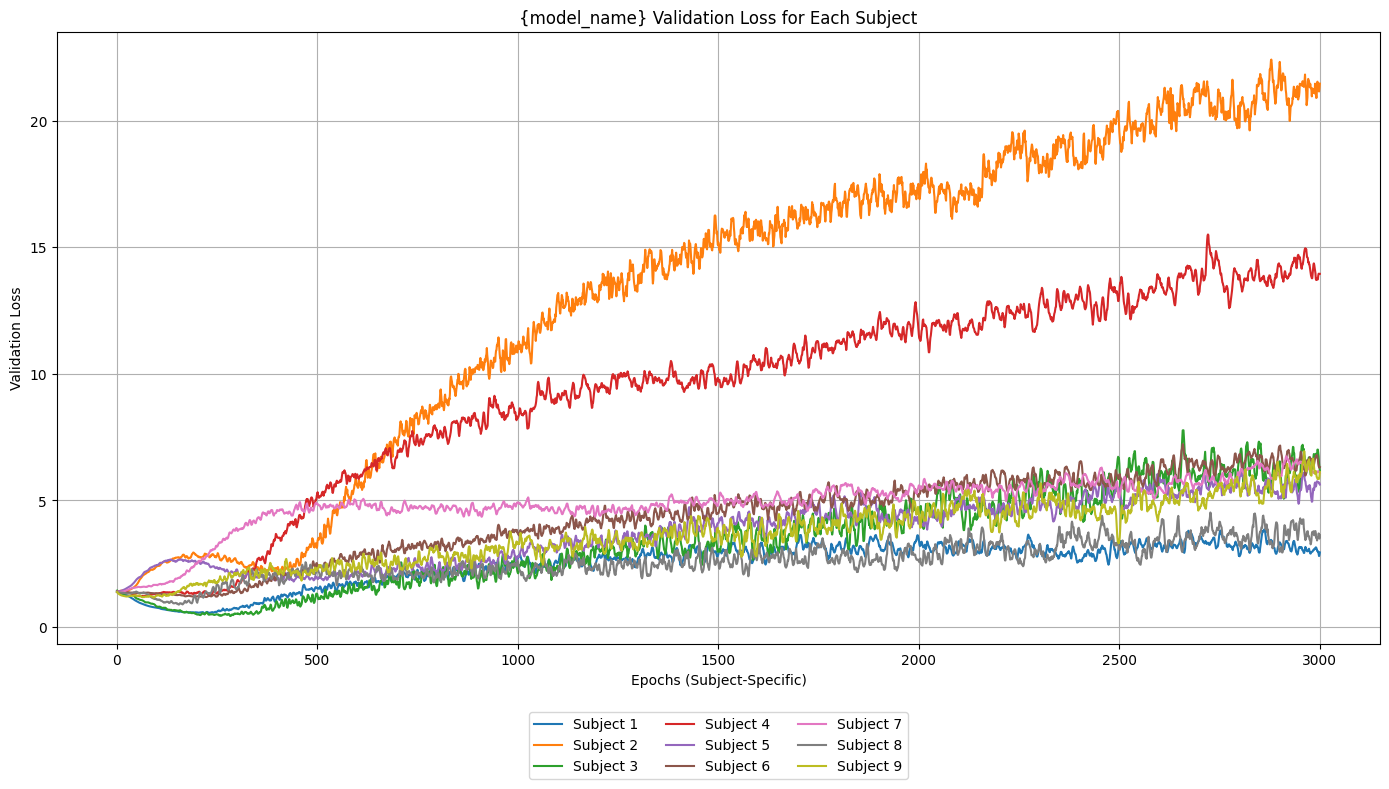

Plotting subject-specific validation loss for SubjectDicionaryFCNet...


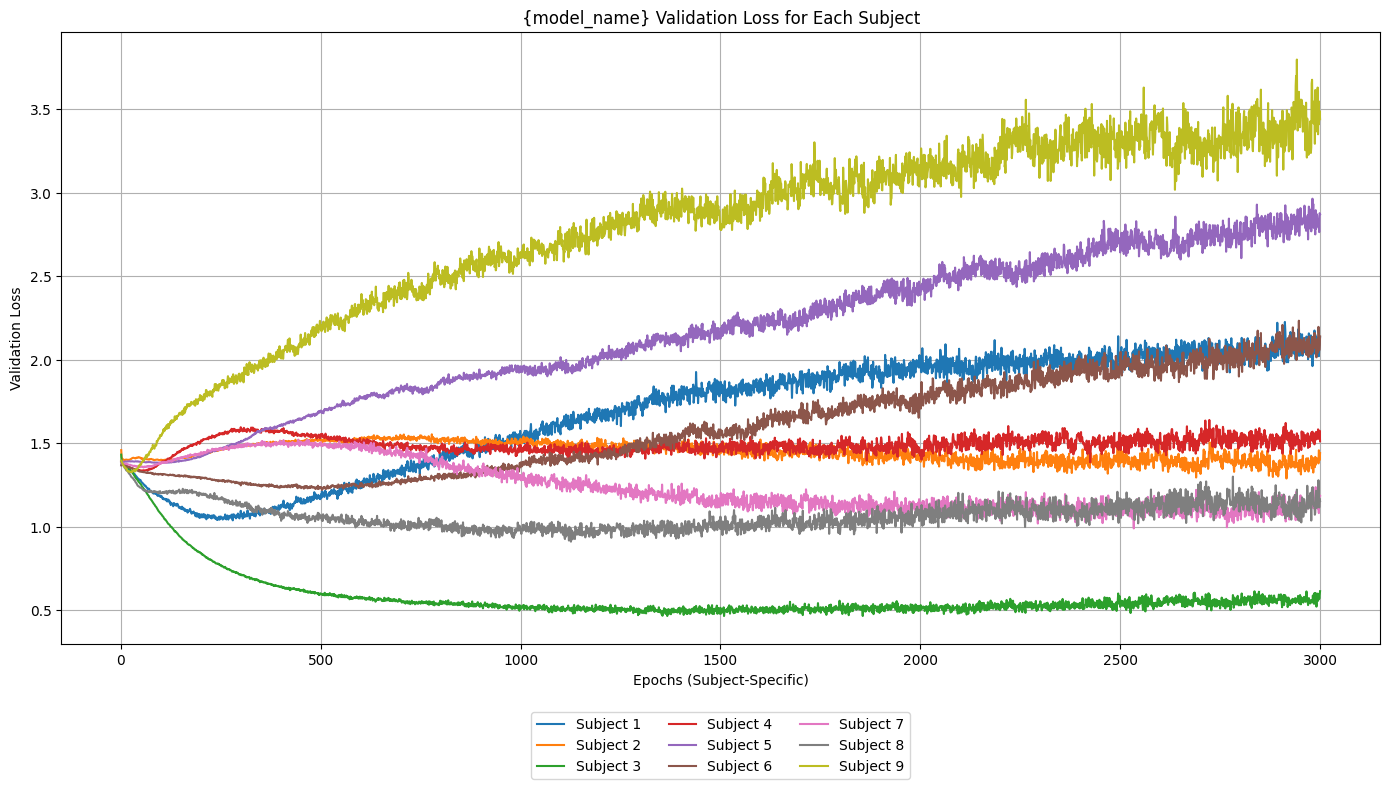

Plotting subject-specific validation loss for ShallowPrivateTemporalDictNetSlow...


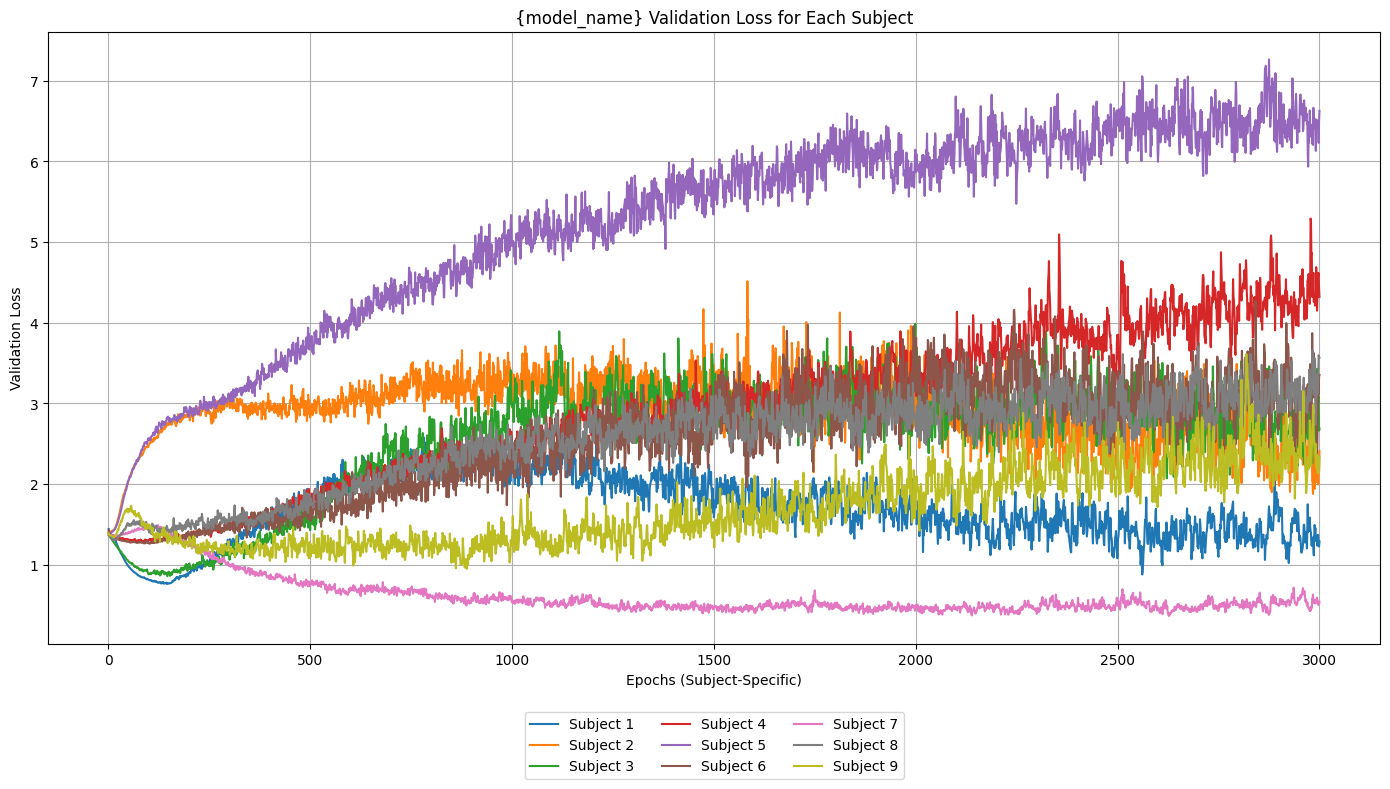

Plotting subject-specific validation loss for ShallowPrivateCollapsedDictNetSlow...


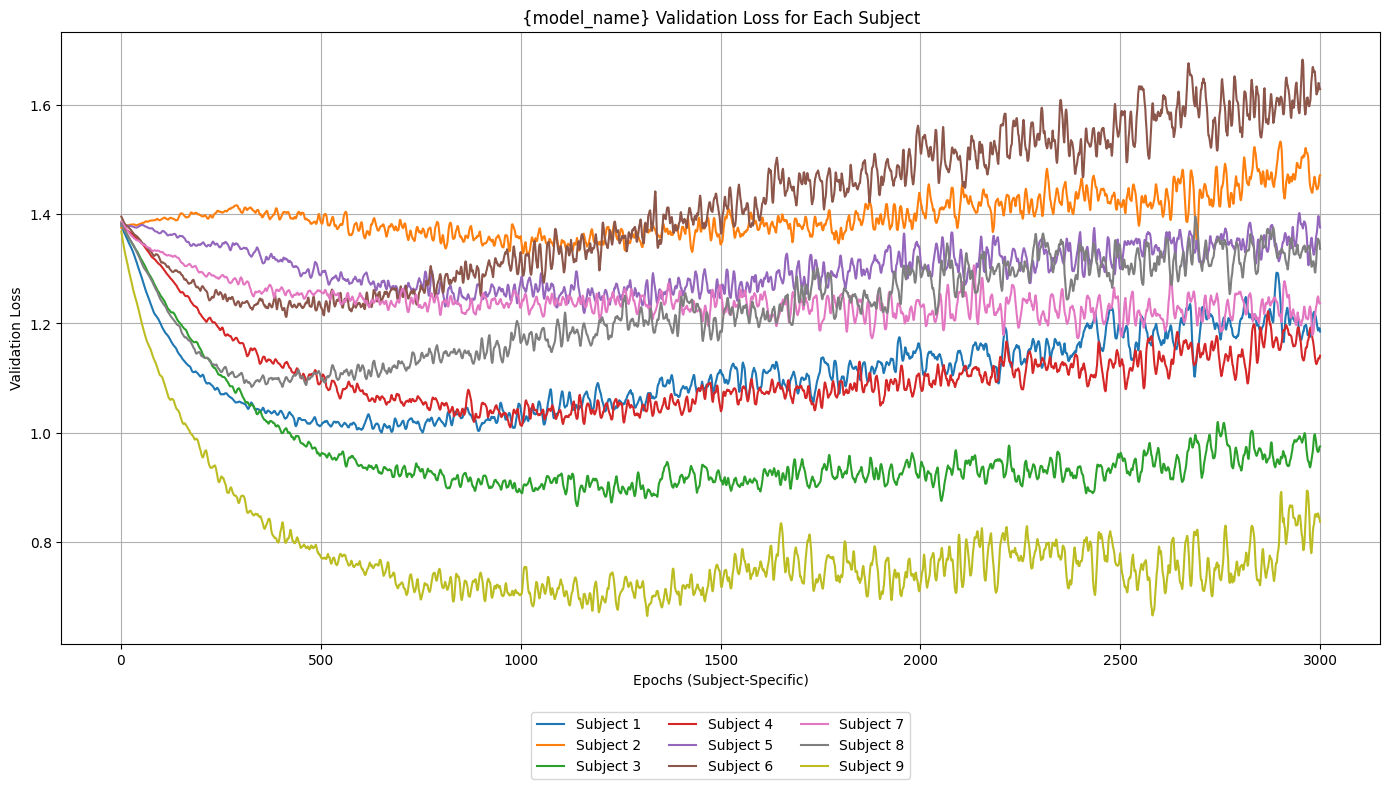

Plotting subject-specific validation loss for ShallowFBCSPNet...


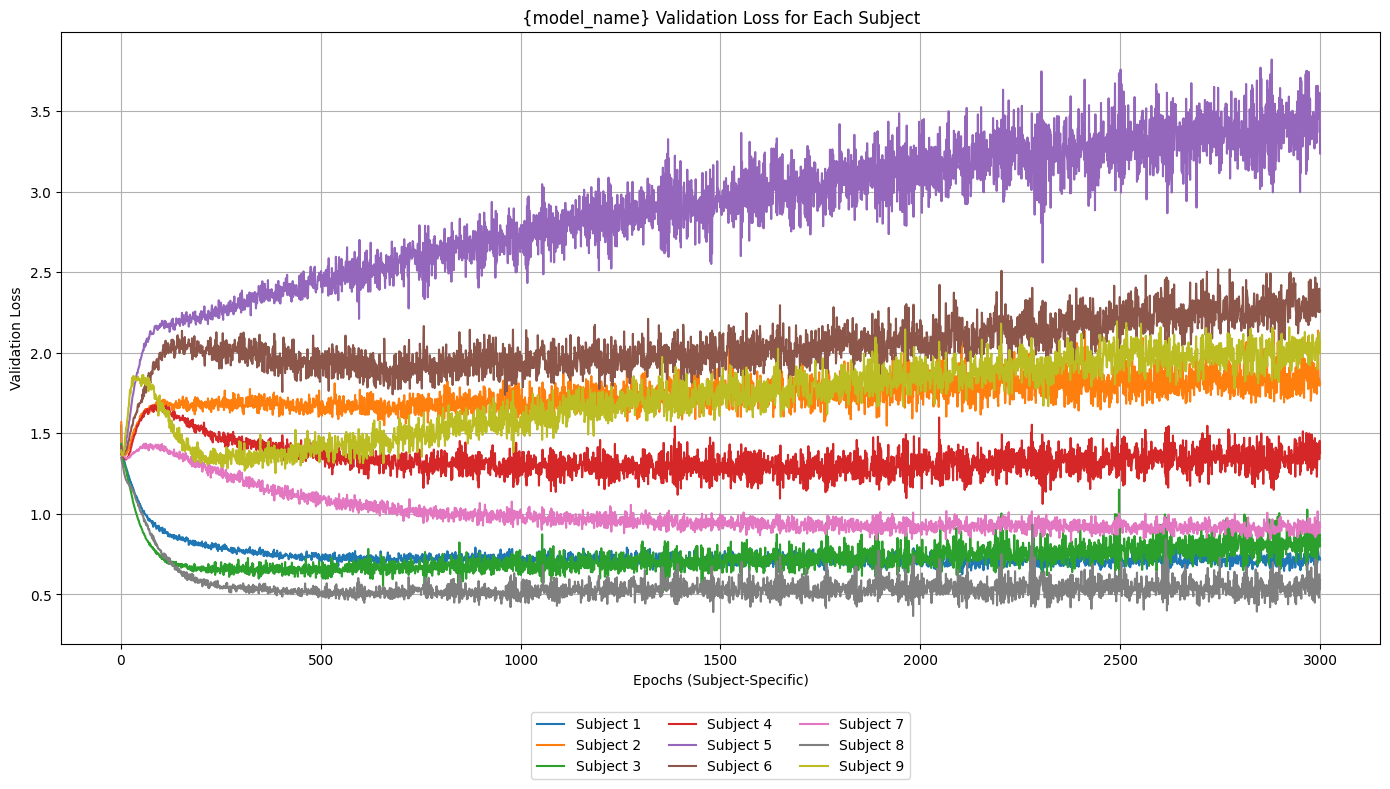

Plotting subject-specific validation loss for CollapsedShallowNet...


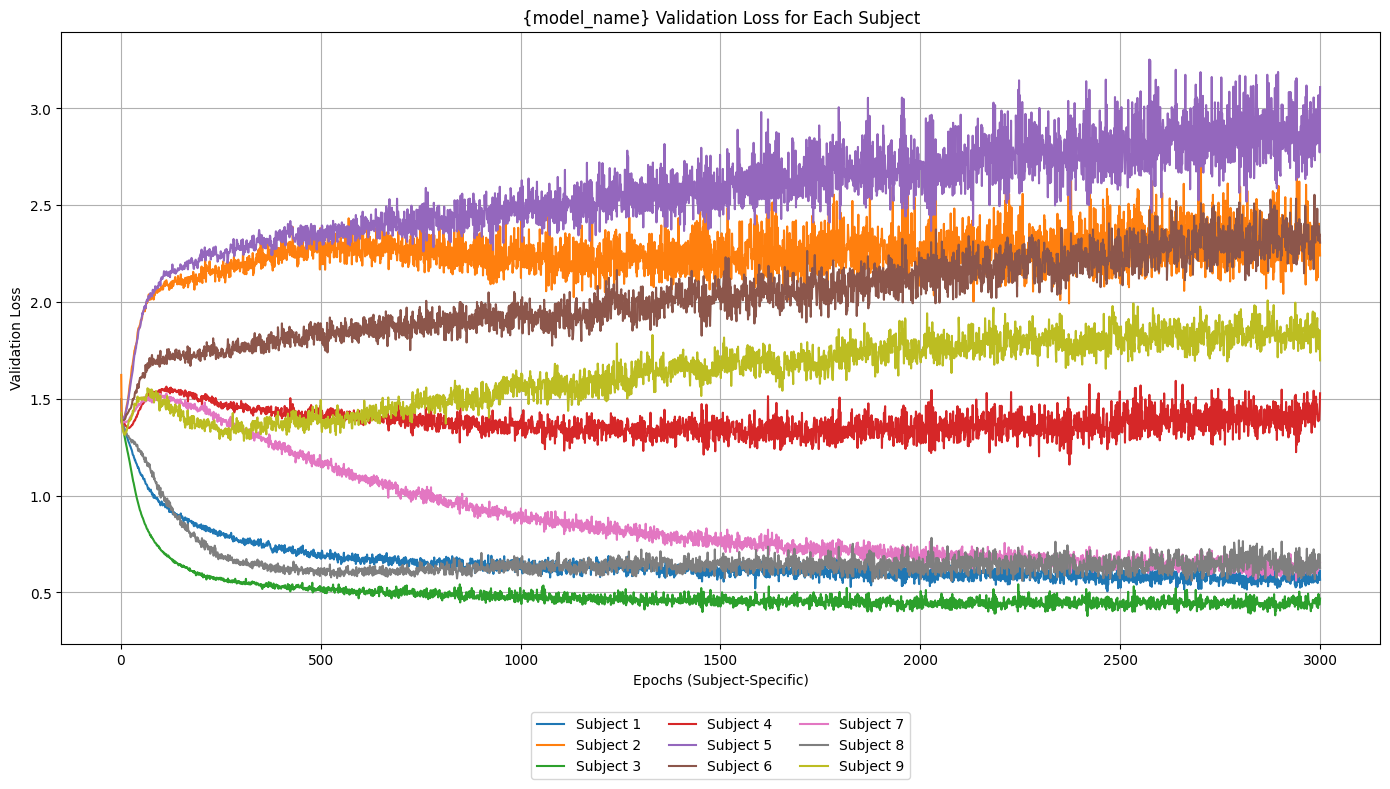

In [3]:
for model in model_data:
    model_name = model['model'].split('.')[-1]  # Get the class name
    epochs = model['epochs']
    if not epochs:
        continue  # Skip if no epoch data is available
    

    epochs = [e for e in epochs if e['epoch'] <= 27000]
    
    # Extract validation loss
    valid_los = [e['valid_loss'] for e in epochs]
    
    # Call the subject-specific validation loss plotting function
    print(f"Plotting subject-specific validation loss for {model_name}...")
    plot_subject_validation_loss(valid_los, num_subjects=9, model_name=model_name)
